## 加载红酒数据

In [115]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

## 数据处理

- 转换到ndarray
- 分成train和test两部分数据
- 标准化

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

## 计算类别的均值向量

In [117]:
import numpy as np

np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1])) 

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



## 计算类内Scatter矩阵（未缩放）

In [118]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X[y == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))
        

Within-class scatter matrix: 13x13


## 计算类内散布矩阵（缩放）

In [119]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    # 直接求协方差矩阵就可以了，正好相当于缩放过的散布矩阵
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))


Within-class scatter matrix: 13x13


## 计算类间散布矩阵

In [120]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    # 类别i的数量
    n = X[y==i+1, :].shape[0] 
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Between-class scatter matrix: 13x13


## 提取特征值

In [121]:
# 通过数据公式推导，最终也转化为一个求矩阵特征值的问题 
# 参见 https://algorithmsdatascience.quora.com/PCA-4-LDA-Linear-Discriminant-Analysis
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

## 按照特征值大小降序排列

In [122]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)
print('Eigenvalues in DESC order: \n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in DESC order: 

643.015384346
225.086981854
8.00267518379e-14
5.75753461418e-14
3.51050796047e-14
3.46389583683e-14
2.58781151001e-14
2.58781151001e-14
2.44498173106e-14
1.65321991297e-14
8.33122517135e-15
2.3238388797e-15
6.52243007612e-16


## 绘制特征向量和区分度的关系图

/Users/HuyuanTu/anaconda/lib/python3.6/site-packages/matplotlib/patches.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
/Users/HuyuanTu/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


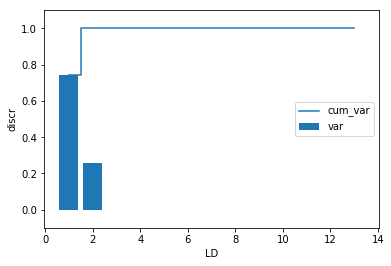

In [123]:
tot = sum(eigen_vals)
# 区分度
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
# 累计区分度
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(1, 14), discr, align='center', label='var')
plt.step(range(1, 14), cum_discr, where='mid', label='cum_var')
plt.ylabel('discr')
plt.xlabel('LD')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()


## 组合转换矩阵

In [124]:
# w shape is 13 * 2
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

## 映射到新的样本空间

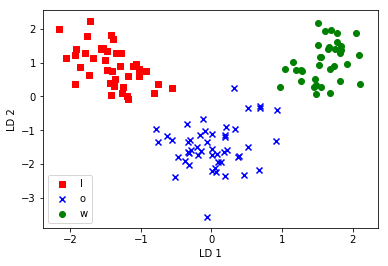

In [125]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

# zip [a, b, c] [1, 2, 3] = [(a, 1), (b, 2), (c, 3)]
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend('lower left')
plt.show()
# 非常好区分，一目了然

## 使用scikit-learn进行LDA分析

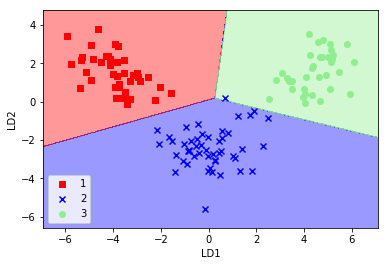

In [126]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    """ 工具方法：分类并画出决策区域图 """
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface using contour 
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class sample
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], c=cmap(idx), marker=markers[idx], label=cl)
        
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()




## 查看测试集的表现

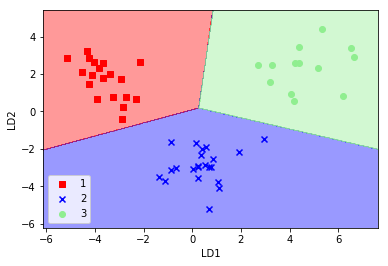

In [127]:
X_test_lda = lda.fit_transform(X_test_std, y_test)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

